# 2.7.3 The Glucose Minimal Model (Fitting Parameters)

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [ ]:
#@title
# Import necessary libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')
download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/chap06.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
from ModSimPy_Functions.chap06 import *
import pandas as pd
import numpy as np

Downloaded ModSimPy_Functions/modsim.py
Downloaded ModSimPy_Functions/chap06.py


The effects of the parameters in the glucose and insulin models ($k_1, k_2, etc...$) is significant.  But how do we actually choose the parameters so that our model matches our known data?

<br>

In this notebook, we'll use a well-known method to do just that.

## The Least Squares Method

Earlier in the course, we fit linear and exponential curves to our world population data by the guess-and-check method: guess at a slope, say, and then check to see how close it matches the data. But with 4 parameters that gets very difficult, and we would never know if we've found the best set of parameters.  

<br>

So we'll use another "blackbox" algorithm to help us out: a SciPy function called `leastsq`, which stands for "least squares".  A least squares algorithm finds parameters by minimizing the sum of squared differences between the results of the model and the known data points.  

<bt> To do this, the algorithm follows this process:

<br>

* Runs the simulation with an initial guess at the parameters
* Calculates the error (the difference between the model and the known data) at each data point
* Squares the error at each data point and sums up these squares
* "Guesses" at values of parameters based on first result, in the hopes of reducing the sum of the squared errors
* Runs the simulation with new "guessed" parameters
* Calculates the error on the this second run.
* Continues this loop until the error reaches some set value.  At this point, we say that the algorithm has "converged" on the optimal answer.



✅ ✅ Read through the process described above.  Why is the method called the "Least squares" method?

✅ ✅ Answer here

### Step 1: Compute the error

Before we can minimize the error, though, we need a way to compute it.  To do this, we'll evaluate our model at each time step where we have known data, and then find the difference between the model and the known data at that time step.  In the end, we'll have a Series that contains the error at of these time steps.

<br>

To begin, we'll import our data and create a system, using the parameters and the `make_system` function from the previous notebook:

In [ ]:
filename = 'https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Images_and_Data/Data/glucose_insulin.csv'
data = pd.read_csv(filename, index_col='time')

Because of the way `leastsq()` is set up, we'll need to rework `make_system` so that it imports the parameters as a "tuple": a foundational Python object that is simply a list of objects.  Notice we also no longer need a `state` object, since `run_solve_ivp` takes care of that:

In [ ]:
G0 = 270.0
k1 = 0.02
k2 = 0.02
k3 = 1.5e-05
dt = 2
# Pack the parameters into a tuple
params = G0, k1, k2, k3, dt

def make_system(params, data):
    # Unpack the paremeters tuple
    G0, k1, k2, k3, dt = params
    t_0 = data.index[0]
    t_end = data.index[-1]

    Gb = data.glucose[t_0]
    Ib = data.insulin[t_0]
    I = interp1d(data.insulin.index,data.insulin.values)

    init = pd.Series(dict(G=G0, X=0),dtype=np.float64)
    system = dict(init=init,
                  k1=k1,k2=k2,
                  k3=k3,dt=dt,
                  Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end)

    return system

system = make_system(params,data)


Now we'll run the initial value problem solver.

In [ ]:
results, details = run_solve_ivp(system, slope_func, t_eval=data.index)
details.message

'The solver successfully reached the end of the integration interval.'

Because we specify `t_eval=data.index`, the results are evaluated at the same time stamps as the data.

In [ ]:
results.tail()

,G,X
102,80.894528,0.003535
122,80.997119,0.001861
142,83.257581,0.000384
162,86.293945,-0.000459
182,89.405110,-0.001178


We can plot the results like this.

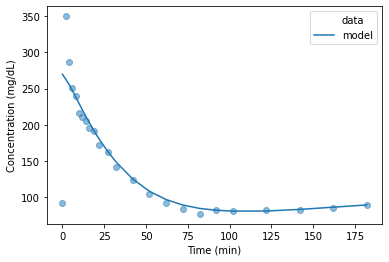

In [ ]:
data.glucose.plot(style='o', alpha=0.5, label='data',
                  legend=True)
results.G.plot(style='-', color='C0', label='model',
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)',
              legend=True);

We can compute the errors by subtracting one data set from the other (this is why it was important that our results be evaluated at the same time steps as our data: otherwise, we couldn't add or subtract them):

In [ ]:
errors = results.G - data.glucose
pd.DataFrame(errors).head()

,0
0,178.000000
2,-87.019058
4,-31.316545
6,-3.684558
8,-1.728149


Most of the errors are under $10 mg/dL$.  But notice that during the first three time steps, the model does not fit the data. This is not surprising.  If you remember, the concentration of glucose in the blood stream initially varies widely (very high near the injection point, for inistance).  That's hard to capture in one number.  But as the glucose disperses in the blood stream, our model matches pretty well.

✅ Active reading: The first three data points in the model are not very accurate.  Considering that the errors are squared in the least squares method, why might we not want to include these data points when we calculate the least squares?

✅ ✅ Answer here.

### Step 2: Put the Process of Finding the Error in a Function

Remember that when we used `root_scalar`, we defined an error function that calculated how close the final temperature of our model coffee was to our known experimental value of 70 degrees.

<br>

We are going to do the same thing here, but now we want the error func to return an array of errors (i.e. that does exactly what we did in the previous section).  `leastsq` will then run our model while changing the paramters, trying to make the sum of this array equal to zero.

<br>

Here's the error function that does this:

In [ ]:
def error_func(params,data):
    system = make_system(params, data)
    results, details = run_solve_ivp(system, slope_func,
                                     t_eval=data.index)
    errors = results.G - data.glucose
    return errors.iloc[3:]

`error_func` uses the given parameters to make a `System` object, runs the simulation, and returns the errors.

<br>

But notice that it does not return all of the errors; rather, it uses the "index location" tool `iloc` to select only the elements with index 3 or more. In other words, it omits the elements with index 0, 1, and 2: the first three data points with large errors.  Since we don't expect the model to fit the data in this region, and since the errors in that region would overwhelm the errors elsewhere, we'll leave them out.

<br>

We can call `error_func` like this:

In [ ]:
errors = error_func(params, data)
errors.head()

(270.0, 0.02, 0.02, 1.5e-05, 2)


6     -3.684558
8     -1.728149
10    13.294083
12     9.425807
14     6.752546
dtype: float64

✅ ✅ Active reading: Look at the code in our `error_func`.  Explain what happens in this function here.

✅ ✅ Answer here.

### Step 3: Run `leastsq` to Minimize the Error Function

Now we're ready to call `leastsq`.  As arguments, we pass `error_func`, the parameters where we want to start the search (this is why we had to change `make_system` to include `params`), and the data, which will be passed as an argument to `error_func`.

In [ ]:
best_params, fit_details = leastsq(error_func, params, data)

[2.7e+02 2.0e-02 2.0e-02 1.5e-05 2.0e+00]
[2.7e+02 2.0e-02 2.0e-02 1.5e-05 2.0e+00]
[2.7e+02 2.0e-02 2.0e-02 1.5e-05 2.0e+00]
[2.70000004e+02 2.00000000e-02 2.00000000e-02 1.50000000e-05
 2.00000000e+00]
[2.70000000e+02 2.00000003e-02 2.00000000e-02 1.50000000e-05
 2.00000000e+00]
[2.70000000e+02 2.00000000e-02 2.00000003e-02 1.50000000e-05
 2.00000000e+00]
[2.70000000e+02 2.00000000e-02 2.00000000e-02 1.50000002e-05
 2.00000000e+00]
[2.70000000e+02 2.00000000e-02 2.00000000e-02 1.50000000e-05
 2.00000003e+00]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05
 2.00000000e+00]
[2.71539227e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05
 2.00000000e+00]
[2.71539223e+02 2.40776796e-02 1.85336372e-02 1.31312411e-05
 2.00000000e+00]
[2.71539223e+02 2.40776792e-02 1.85336375e-02 1.31312411e-05
 2.00000000e+00]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312413e-05
 2.00000000e+00]
[2.71539223e+02 2.40776792e-02 1.85336372e-02 1.31312411e-05
 2.00000003e+00]
[2.70733829e+02 

Each time `error_func` is called, it prints the parameters, so we can get a sense of how `leastsq` works.   Look at one of the printed columns: do you see how it starts at the given value (say, 270 for G0) and then starts to change?   Each line represents another "guess" by the `leastsq` algorithm, and with each guess, it searches out a smaller sum of the squares of the errors.  This process is called *iteration*.

<br>

Notice that in the last few iterations, the values of the parameters are changing by miniscule amounts: at this point, the algorithm is narrowing down the values to its final answer, which is the set of parameters that minimize the sum of the squares of the errors.

<br>

`leastsq` has two return values.  The first is an array with the best parameters:

In [ ]:
best_params

array([2.71814096e+02, 2.41754652e-02, 1.58792698e-02, 1.27619836e-05,
       2.00000000e+00])

The second is an object with information about the results, including a success flag and a message.

In [ ]:
fit_details.success

True

In [ ]:
fit_details.mesg

'The relative error between two consecutive iterates is at most 0.000000'

This means that the last two iterations produced nearly identical results, and is a sign that the iteration process is complete.

### Step 4: Checking our Results

Now that we have `best_params`, we can use it to make a `System` object, run the simulation, and see how accurate our results are.

The solver successfully reached the end of the integration interval.


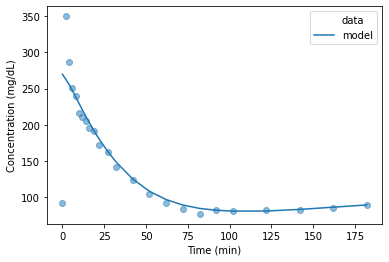

In [ ]:
system2 = make_system(best_params, data)
results2, details = run_solve_ivp(system2, slope_func, t_eval=data.index)
print(details.message)
data.glucose.plot(style='o', alpha=0.5, label='data',
                 legend=True)
results.G.plot(style='-', color='C0', label='model',
               xlabel='Time (min)',
               ylabel='Concentration (mg/dL)',
              legend=True);


Now we can compute the errors directly.  What kind of value do we expect?

In [ ]:
errors2 = results2.G - data.glucose
errors2.head()

0    179.814096
2    -86.706790
4    -32.315308
6     -5.750628
8     -4.797090
dtype: float64

Notice that the errors are not zero.  This is because no function of the form that we are using is capable of going through each data point.  The curve is a "best fit", but it is not a *perfect* fit.  

<br>

Let's compare the error resulting from our initial parameters to the error resulting from the `best_params`.   To do this, we want to sum the square of these errors, a process that usually happens *within* the function `leastsq`.   Here are the results:

In [ ]:
from numpy import sum

init_param_error = sum(errors.iloc[3:]**2)
best_param_error = sum(errors2.iloc[3:]**2)
print("The sum of squared errors for the initial params is", round(init_param_error,1))
print("The sum of squared errors for the best params is", round(best_param_error,1))

The sum of squared errors for the initial params is 626.2
The sum of squared errors for the best params is 319.7


The absolute size of these numbers is not meaningful: if we had used more time steps, the magnitude of the numbers would be larger.   But we can see that the sum of the squares went down noticeably, and could calculate a percent change:

In [ ]:
rel_change_error = (init_param_error-best_param_error)/init_param_error
print("The size of the sum of squares of the error decreased by",
      round(rel_change_error*100,1), "percent")

The size of the sum of squares of the error decreased by 48.9 percent


✅ ✅  Active reading: Why is the difference between our optimized model and our data not zero?


✅ ✅ Answer here